In [1]:
path = './zomato.csv'
path_kamus = './kamus_alay.csv'

In [2]:
import csv
import os
import glob
import numpy as np
import math
from tqdm import tqdm
#scikit learn
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#stemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

/Users/indraaristya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/indraaristya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/indraaristya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def cleaning(sentence):
    sentence = sentence.replace('\ufeff','')
    sentence = sentence.replace('\n',' ')
    sentence = sentence.replace('\r',' ')
    sentence = sentence.replace('\n\n',' ')
    sentence = sentence.replace('\r\r',' ')
    sentence = sentence.replace('.',' ')
    sentence = sentence.replace(',',' ')
    sentence = sentence.replace('"',' ')
    sentence = sentence.replace('!',' ')
    sentence = sentence.replace('?',' ')
    sentence = sentence.replace('/',' ')
    sentence = sentence.replace('-',' ')
    sentence = sentence.lstrip()
    return sentence.lower()

In [4]:
def convert(sentences):
    import re
    cleanEmoticon = []
    for sentence in sentences:
        try:
            highpoints = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
        except re.error:
            highpoints = re.compile(u'([\u2600-\u27BF])|([\uD83C][\uDF00-\uDFFF])|([\uD83D][\uDC00-\uDE4F])|([\uD83D][\uDE80-\uDEFF])')
    
        cleanEmoticon.append(highpoints.sub(u'\u25FD', sentence))
    return cleanEmoticon

In [9]:
def preprocess(sentences): 
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    result =[]
    for sentence in sentences:
        result.append(stemmer.stem(stopword.remove(sentence)))
    return result

In [5]:
# x = []
# y = []
# with open(path, encoding="utf8") as a:
#     b = csv.reader(a)
#     for row in b:
#         x.append(cleaning(row[2]))
#         y.append(row[3])
# x = np.array(x)
# y = np.array(y)

In [6]:
# randomize = np.arange(len(x))
# np.random.shuffle(randomize)
# x = x[randomize]
# y = y[randomize]

In [7]:
# x_train = x[:150]
# y_train = y[:150]

# x_test = x[150:]
# y_test = y[150:]

In [ ]:
# x_train = preprocess(x_train)
# x_test = preprocess(x_test)

In [ ]:
# x_train = convert(x_train)
# x_test = convert(x_test)

## Cleaning using Kamus Alay

In [39]:
alay = []
benar = []
with open(path_kamus, encoding="utf8") as a:
    b = csv.reader(a)
    for row in b:
        alay.append(row[0])
        benar.append(row[1])

In [40]:
x = []
y = []
with open(path, encoding="utf8") as a:
    b = csv.reader(a)
    for row in b:
        x.append(cleaning(row[2]))
        y.append(row[3])
x = np.array(x)
y = np.array(y)

x_alay = np.array(x)

In [41]:
for i in tqdm(range(len(x))):
    splitted = x[i].split()
    for j in range(1,len(alay)):
        for k in range(0,len(splitted)):
            if splitted[k] == alay[j]:
                splitted[k] = benar[j]
    x_alay[i] = ' '.join(str(e) for e in splitted)

100%|██████████| 200/200 [00:39<00:00,  5.08it/s]


In [42]:
def count_word_in_class(x,y):
    count = {}
    count_word = {}
    word_class = {}
    for i in range(0, len(x)):
        x_split = x[i].split()
        for word in x_split:
            w_c = word+str(",")+str(y[i])
            if (w_c in count):
                count[w_c] += 1
            else:
                count[w_c] = 1
                
            if (word in count_word):
                count_word[word] += 1
            else:
                count_word[word] = 1
                
            if (y[i] in word_class):
                word_class[y[i]] += 1
            else:
                word_class[y[i]] = 1
    return count, count_word, word_class

def count_class_in_doc(y):
    count = {}
    for i in range(0, len(y)):
        if (y[i] in count):
            count[y[i]] += 1
        else:
            count[y[i]] = 1
    return count

def hitung_prob(count,word,uniq):
    return ((count + 1)/(word+uniq))

In [43]:
randomize = np.arange(len(x))
np.random.shuffle(randomize)
x = x[randomize]
y = y[randomize]
x_alay = x_alay[randomize]

In [44]:
x_train = x[:150]
y_train = y[:150]

x_train_alay = x_alay[:150]
x_test_alay = x_alay[150:]

x_test = x[150:]
y_test = y[150:]

In [45]:
acc_stem = []
acc_non_stem = []

In [47]:
x_train = convert(x_train)
x_train_alay = convert(x_train_alay)
x_test = convert(x_test)
x_test_alay = convert(x_test_alay)

## Multinomial Naive Bayes

In [48]:
count_word_on_class, count_word, word_class = count_word_in_class(x_train,y_train)
count_word_on_class_alay, count_word_alay, word_class_alay = count_word_in_class(x_train_alay,y_train)

In [49]:
count_class = count_class_in_doc(y_train)

kelaz = list(count_class.keys())
y_pred = []
for i in range(0,len(x_test)):
    prob_kelas = {}
    for j in count_class.keys():
        prob_c = 1
        x_split = x_test[i].split()
        for k in x_split:
            tag = k+str(',')+str(j)
            prob_c += math.log(hitung_prob(count_word_on_class.get(tag,0),word_class.get(j),len(count_word.keys())))
        nama = str(i)+','+str(j)
        prob_kelas[nama] = prob_c
    y_pred.append(kelaz[np.argmax(list(prob_kelas.values()))])

kelaz = list(count_class.keys())
y_pred_alay = []
for i in range(0,len(x_test_alay)):
    prob_kelas = {}
    for j in count_class.keys():
        prob_c = 1
        x_split = x_test_alay[i].split()
        for k in x_split:
            tag = k+str(',')+str(j)
            prob_c += math.log(hitung_prob(count_word_on_class_alay.get(tag,0),word_class_alay.get(j),len(count_word_alay.keys())))
        nama = str(i)+','+str(j)
        prob_kelas[nama] = prob_c
    y_pred_alay.append(kelaz[np.argmax(list(prob_kelas.values()))])
    

In [50]:
acc = accuracy_score(y_test, y_pred)*100
acc_alay = accuracy_score(y_test, y_pred_alay)*100

acc_non_stem.append(acc)
acc_non_stem.append(acc_alay)

print("Akurasi (Pre-Processing dengan Korpus Alay): ",acc_alay)
print("Akurasi (Pre-Processing tanpa Korpus Alay): ",acc)

Akurasi (Pre-Processing dengan Korpus Alay):  72.0
Akurasi (Pre-Processing tanpa Korpus Alay):  68.0


In [51]:
# print(classification_report(y_pred, y_test))
# print(classification_report(y_pred_alay, y_test))

## SVM Linear

In [52]:
text_clf_alay = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC(kernel = 'linear')),
])
text_clf_alay = text_clf_alay.fit(x_train_alay, y_train)
y_pred_svm_alay = text_clf_alay.predict(x_test_alay)

acc_alay = accuracy_score(y_test, y_pred_svm_alay)*100

text_clf = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC(kernel = 'linear')),
])
text_clf = text_clf.fit(x_train, y_train)
y_pred_svm = text_clf.predict(x_test)

acc = accuracy_score(y_test, y_pred_svm)*100

acc_non_stem.append(acc)
acc_non_stem.append(acc_alay)

print("Akurasi (Pre-Processing dengan Korpus Alay): ",acc_alay)
print("Akurasi (Pre-Processing tanpa Korpus Alay): ",acc)

Akurasi (Pre-Processing dengan Korpus Alay):  78.0
Akurasi (Pre-Processing tanpa Korpus Alay):  74.0


In [53]:
# print(classification_report(y_pred_svm_alay, y_test))

In [54]:
# print(classification_report(y_pred_svm, y_test))

## kNN 

In [55]:
text_clf_alay = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(n_neighbors=1)),
])
text_clf_alay = text_clf_alay.fit(x_train_alay, y_train)
y_pred_knn_alay = text_clf_alay.predict(x_test_alay)

acc_alay = accuracy_score(y_test, y_pred_knn_alay)*100

text_clf = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(n_neighbors=1)),
])
text_clf = text_clf.fit(x_train, y_train)
y_pred_knn = text_clf.predict(x_test)

acc = accuracy_score(y_test, y_pred_knn)*100

acc_non_stem.append(acc)
acc_non_stem.append(acc_alay)

print("Akurasi (Pre-Processing dengan Korpus Alay): ",acc_alay)
print("Akurasi (Pre-Processing tanpa Korpus Alay): ",acc)

Akurasi (Pre-Processing dengan Korpus Alay):  64.0
Akurasi (Pre-Processing tanpa Korpus Alay):  64.0


In [ ]:
# print(classification_report(y_pred_knn, y_test))
# print(classification_report(y_pred_knn_alay, y_test))

## Multinomial Naive Bayes, SVM Linear, kNN dengan preprocessing Kamus Alay

In [57]:
x_train = preprocess(x_train)
x_train_alay = preprocess(x_train_alay)
x_test_alay = preprocess(x_test_alay)
x_test = preprocess(x_test)

x_train = convert(x_train)
x_train_alay = convert(x_train_alay)
x_test = convert(x_test)
x_test_alay = convert(x_test_alay)

count_word_on_class, count_word, word_class = count_word_in_class(x_train,y_train)
count_word_on_class_alay, count_word_alay, word_class_alay = count_word_in_class(x_train_alay,y_train)

count_class = count_class_in_doc(y_train)

kelaz = list(count_class.keys())
y_pred = []
for i in range(0,len(x_test)):
    prob_kelas = {}
    for j in count_class.keys():
        prob_c = 1
        x_split = x_test[i].split()
        for k in x_split:
            tag = k+str(',')+str(j)
            prob_c += math.log(hitung_prob(count_word_on_class.get(tag,0),word_class.get(j),len(count_word.keys())))
        nama = str(i)+','+str(j)
        prob_kelas[nama] = prob_c
    y_pred.append(kelaz[np.argmax(list(prob_kelas.values()))])

kelaz = list(count_class.keys())
y_pred_alay = []
for i in range(0,len(x_test_alay)):
    prob_kelas = {}
    for j in count_class.keys():
        prob_c = 1
        x_split = x_test_alay[i].split()
        for k in x_split:
            tag = k+str(',')+str(j)
            prob_c += math.log(hitung_prob(count_word_on_class_alay.get(tag,0),word_class_alay.get(j),len(count_word_alay.keys())))
        nama = str(i)+','+str(j)
        prob_kelas[nama] = prob_c
    y_pred_alay.append(kelaz[np.argmax(list(prob_kelas.values()))])
    

acc = accuracy_score(y_test, y_pred)*100
acc_alay = accuracy_score(y_test, y_pred_alay)*100

acc_stem.append(acc)
acc_stem.append(acc_alay)

print("Akurasi (Pre-Processing dengan Korpus Alay): ",acc_alay)
print("Akurasi (Pre-Processing tanpa Korpus Alay): ",acc)

# print(classification_report(y_pred, y_test))
# print(classification_report(y_pred_alay, y_test))



text_clf_alay = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC(kernel = 'linear')),
])
text_clf_alay = text_clf_alay.fit(x_train_alay, y_train)
y_pred_svm_alay = text_clf_alay.predict(x_test_alay)

acc_alay = accuracy_score(y_test, y_pred_svm_alay)*100

text_clf = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC(kernel = 'linear')),
])
text_clf = text_clf.fit(x_train, y_train)
y_pred_svm = text_clf.predict(x_test)

acc = accuracy_score(y_test, y_pred_svm)*100

acc_stem.append(acc)
acc_stem.append(acc_alay)

print("Akurasi (Pre-Processing dengan Korpus Alay): ",acc_alay)
print("Akurasi (Pre-Processing tanpa Korpus Alay): ",acc)

# print(classification_report(y_pred_svm_alay, y_test))

# print(classification_report(y_pred_svm, y_test))



text_clf_alay = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(n_neighbors=1)),
])
text_clf_alay = text_clf_alay.fit(x_train_alay, y_train)
y_pred_knn_alay = text_clf_alay.predict(x_test_alay)

acc_alay = accuracy_score(y_test, y_pred_knn_alay)*100

text_clf = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(n_neighbors=1)),
])
text_clf = text_clf.fit(x_train, y_train)
y_pred_knn = text_clf.predict(x_test)

acc = accuracy_score(y_test, y_pred_knn)*100

acc_stem.append(acc)
acc_stem.append(acc_alay)

print("Akurasi (Pre-Processing dengan Korpus Alay): ",acc_alay)
print("Akurasi (Pre-Processing tanpa Korpus Alay): ",acc)

# print(classification_report(y_pred_knn, y_test))
# print(classification_report(y_pred_knn_alay, y_test))

Akurasi (Pre-Processing dengan Korpus Alay):  72.0
Akurasi (Pre-Processing tanpa Korpus Alay):  76.0
Akurasi (Pre-Processing dengan Korpus Alay):  82.0
Akurasi (Pre-Processing tanpa Korpus Alay):  80.0
Akurasi (Pre-Processing dengan Korpus Alay):  72.0
Akurasi (Pre-Processing tanpa Korpus Alay):  66.0


## Plot tanpa Stemming

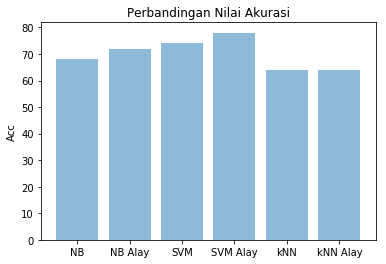

In [64]:
import matplotlib.pyplot as plt

objects = ['NB', 'NB Alay','SVM', 'SVM Alay','kNN', 'kNN Alay']
y_pos = np.arange(len(objects))

a = plt.bar(y_pos, acc_non_stem ,align='center', alpha=0.5)
# a[1].set_color('r')
plt.xticks(y_pos, objects)
plt.ylabel('Acc')
plt.title('Perbandingan Nilai Akurasi')
 
plt.show()

## Plot dengan Stemming

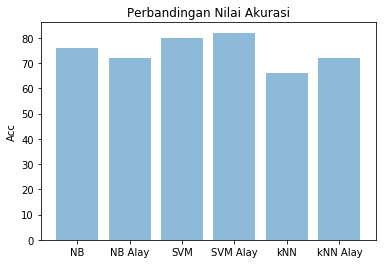

In [58]:
import matplotlib.pyplot as plt

objects = ['NB', 'NB Alay','SVM', 'SVM Alay','kNN', 'kNN Alay']
y_pos = np.arange(len(objects))
 
plt.bar(y_pos, acc_stem ,align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Acc')
plt.title('Perbandingan Nilai Akurasi')
 
plt.show()

## Gabungan Plot dengan dan tanpa Stemming

In [66]:
akurasi = []
for i in range(len(acc_stem)):
    akurasi.append(acc_non_stem[i])
    akurasi.append(acc_stem[i])

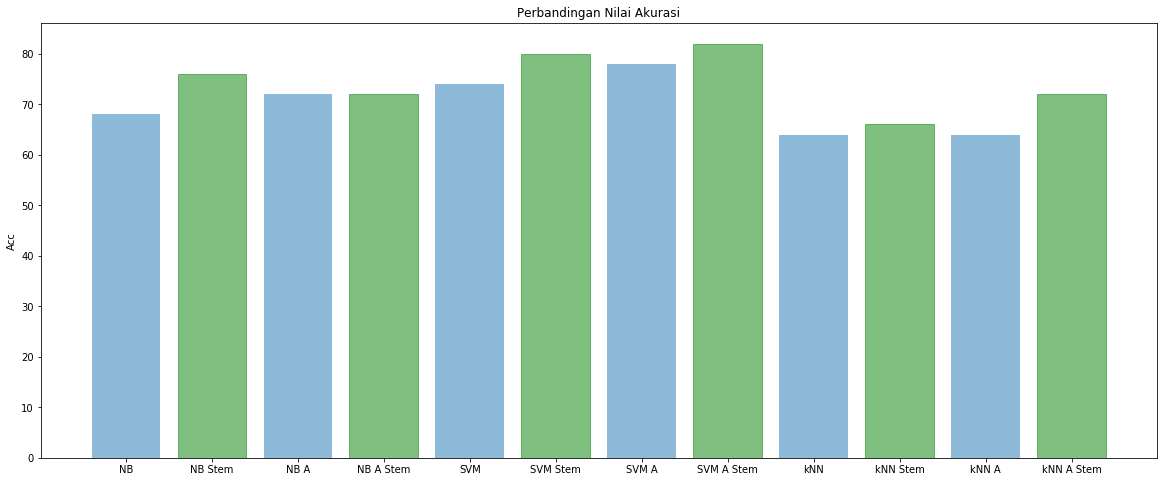

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
objects = ['NB', 'NB Stem','NB A', 'NB A Stem','SVM', 'SVM Stem','SVM A','SVM A Stem','kNN', 'kNN Stem','kNN A', 'kNN A Stem']
y_pos = np.arange(len(objects))
 
bar = plt.bar(y_pos, akurasi , alpha=0.5)
bar[1].set_color('g')
bar[3].set_color('g')
bar[5].set_color('g')
bar[7].set_color('g')
bar[9].set_color('g')
bar[11].set_color('g')
plt.xticks(y_pos, objects)
plt.ylabel('Acc')
plt.title('Perbandingan Nilai Akurasi')
 
plt.show()

## Visualize Train adn Test Data

In [252]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

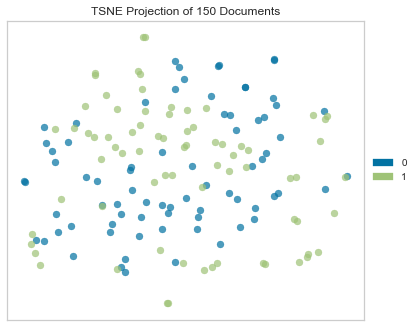

In [253]:
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(x_tfidf_vect, y_train)
tsne.poof()

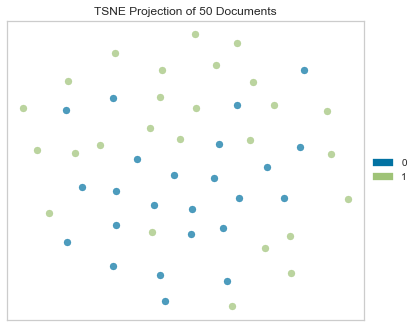

In [254]:
tsne = TSNEVisualizer()
tsne.fit(x_tfidf_vect_test, y_test)
tsne.poof()

## Visualize All Data

In [255]:
vectorizer = TfidfVectorizer()

x_vect = vectorizer.fit(x)
xxx = x_vect.transform(x)

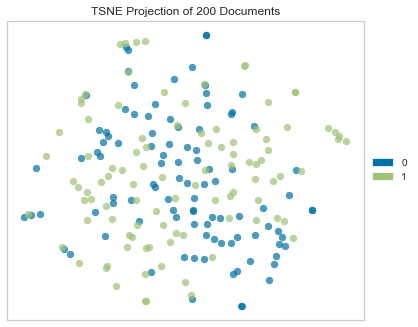

In [256]:
tsne = TSNEVisualizer()
tsne.fit(xxx, y)
tsne.poof()

In [13]:
satu = []
nol = []

for i in range(len(x_train)):
    if (y_train[i] == '1'):
        split = x_train[i].split()
        satu.append(len(split))
    else:
        split = x_train[i].split()
        nol.append(len(split))

print("Satu: ",np.sum(satu)/len(satu))
print("Nol: ",np.sum(nol)/len(nol))

Satu:  66.25
Nol:  81.58974358974359
